In [2]:
%matplotlib inline
import matplotlib.pyplot as pyplot

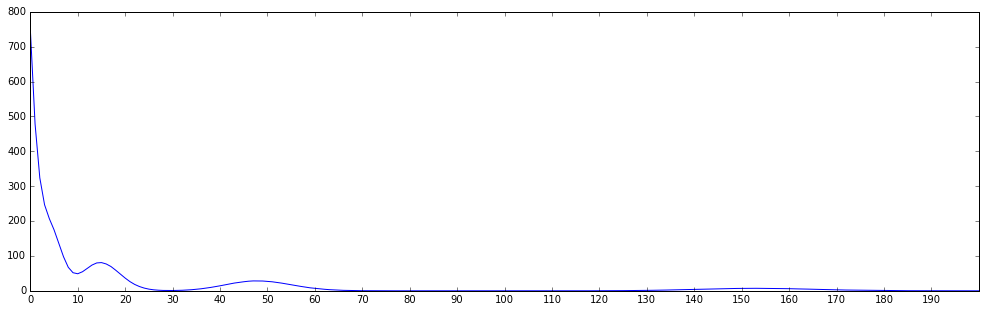

In [31]:
with open('graphs_count_2000_scale_12_average_distribution.txt') as f:
    lines = f.readlines()
distrib = [[int(line.split(" ")[0]), float(''.join(line.split(" ")[1][:-1]))] for line in lines[1:]]
fig = pyplot.figure(figsize=(17,5), dpi=90)
#fig.suptitle(algo + ' algorithm (' + str(experiment.attempts_count) + ' experiments)' , fontsize = 20)
pyplot.plot([_[0] for _ in distrib], [_[1] for _ in distrib])
pyplot.xlim([0, 200])
pyplot.xticks(range(0, 200, 10))
#pyplot.xlabel('size')
#pyplot.ylabel('time, s')
pyplot.show()